In [27]:
!source mlproject/bin/activate

In [28]:
pip install pandas numpy matplotlib scikit-learn seaborn jupyterlab


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install imblearn xgboost


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

# For feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import Lasso, LogisticRegression

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

# For modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Phase 1: Exploratory Data Analysis 

In [31]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully from URL!")
except:
    print("Failed to load from URL. Please download the dataset manually.")
    print("Download from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
    # Uncomment and use local file if download is needed
    # df = pd.read_csv('Telco-Customer-Churn.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Dataset loaded successfully from URL!

Dataset Shape: (7043, 21)
Rows: 7043, Columns: 21


In [32]:
# Basic Information about the dataset
print("="*80)
print("DATASET BASIC INFORMATION")
print("="*80)

# Display first few rows
print("\n📊 First 5 rows:")
print(df.head())

print("\n" + "="*80)
print("\n📋 Dataset Info:")
print(df.info())

print("\n" + "="*80)
print("\n📈 Statistical Summary:")
print(df.describe())

print("\n" + "="*80)
print("\n🔍 Data Types:")
print(df.dtypes.value_counts())

print("\n" + "="*80)
print("\n📌 Column Names:")
print(df.columns.tolist())

DATASET BASIC INFORMATION

📊 First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

DATA QUALITY CHECK

🔄 Duplicate Rows: 0

❓ Missing Values per Column:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
✅ No missing values detected!


🎯 Target Variable Distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

📊 Proportion:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


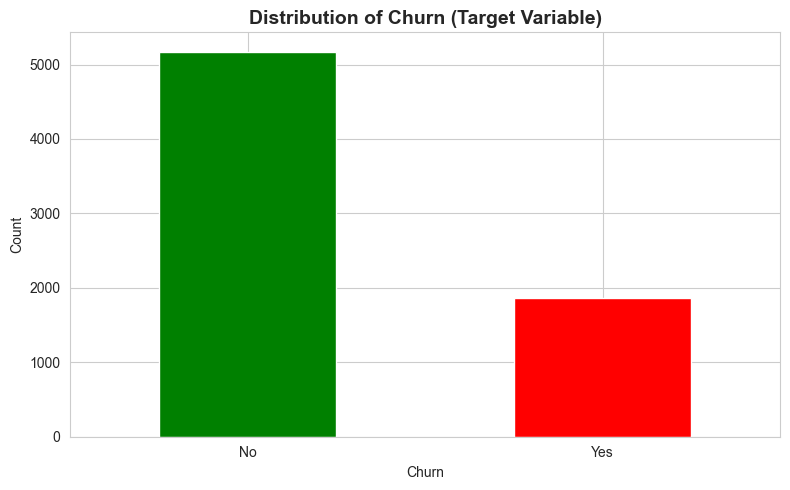

In [33]:
# Check for duplicates and missing values
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

print(f"\n🔄 Duplicate Rows: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    print(f"Removing {df.duplicated().sum()} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New shape: {df.shape}")

print(f"\n❓ Missing Values per Column:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values(by='Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("✅ No missing values detected!")

print("\n" + "="*80)
print("\n🎯 Target Variable Distribution (Churn):")
print(df['Churn'].value_counts())
print("\n📊 Proportion:")
print(df['Churn'].value_counts(normalize=True))

# Visualize target distribution
plt.figure(figsize=(8, 5))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Churn (Target Variable)', fontsize=14, fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Univariate Analysis 

In [34]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable and customerID from lists if present
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')
if 'customerID' in numerical_cols:
    numerical_cols.remove('customerID')

print(f"📊 Numerical Columns ({len(numerical_cols)}): {numerical_cols}")
print(f"📋 Categorical Columns ({len(categorical_cols)}): {categorical_cols}")

📊 Numerical Columns (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']
📋 Categorical Columns (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


HISTOGRAMS FOR NUMERICAL VARIABLES


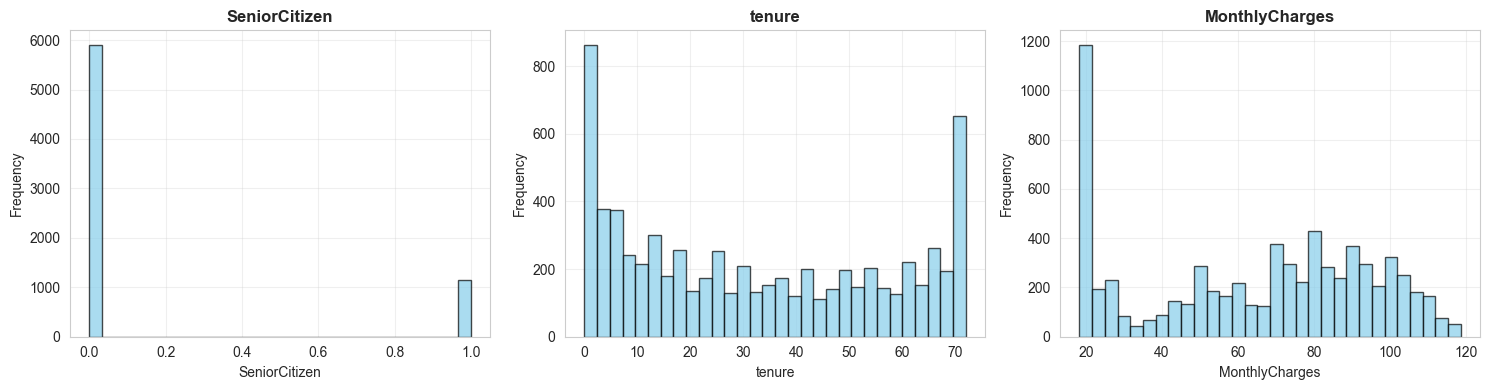


📈 Statistics for Numerical Variables:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [35]:
# Histograms for Numerical Variables
print("="*80)
print("HISTOGRAMS FOR NUMERICAL VARIABLES")
print("="*80)

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 4))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display statistics for numerical variables
print("\n📈 Statistics for Numerical Variables:")
print(df[numerical_cols].describe())

BAR PLOTS FOR CATEGORICAL VARIABLES


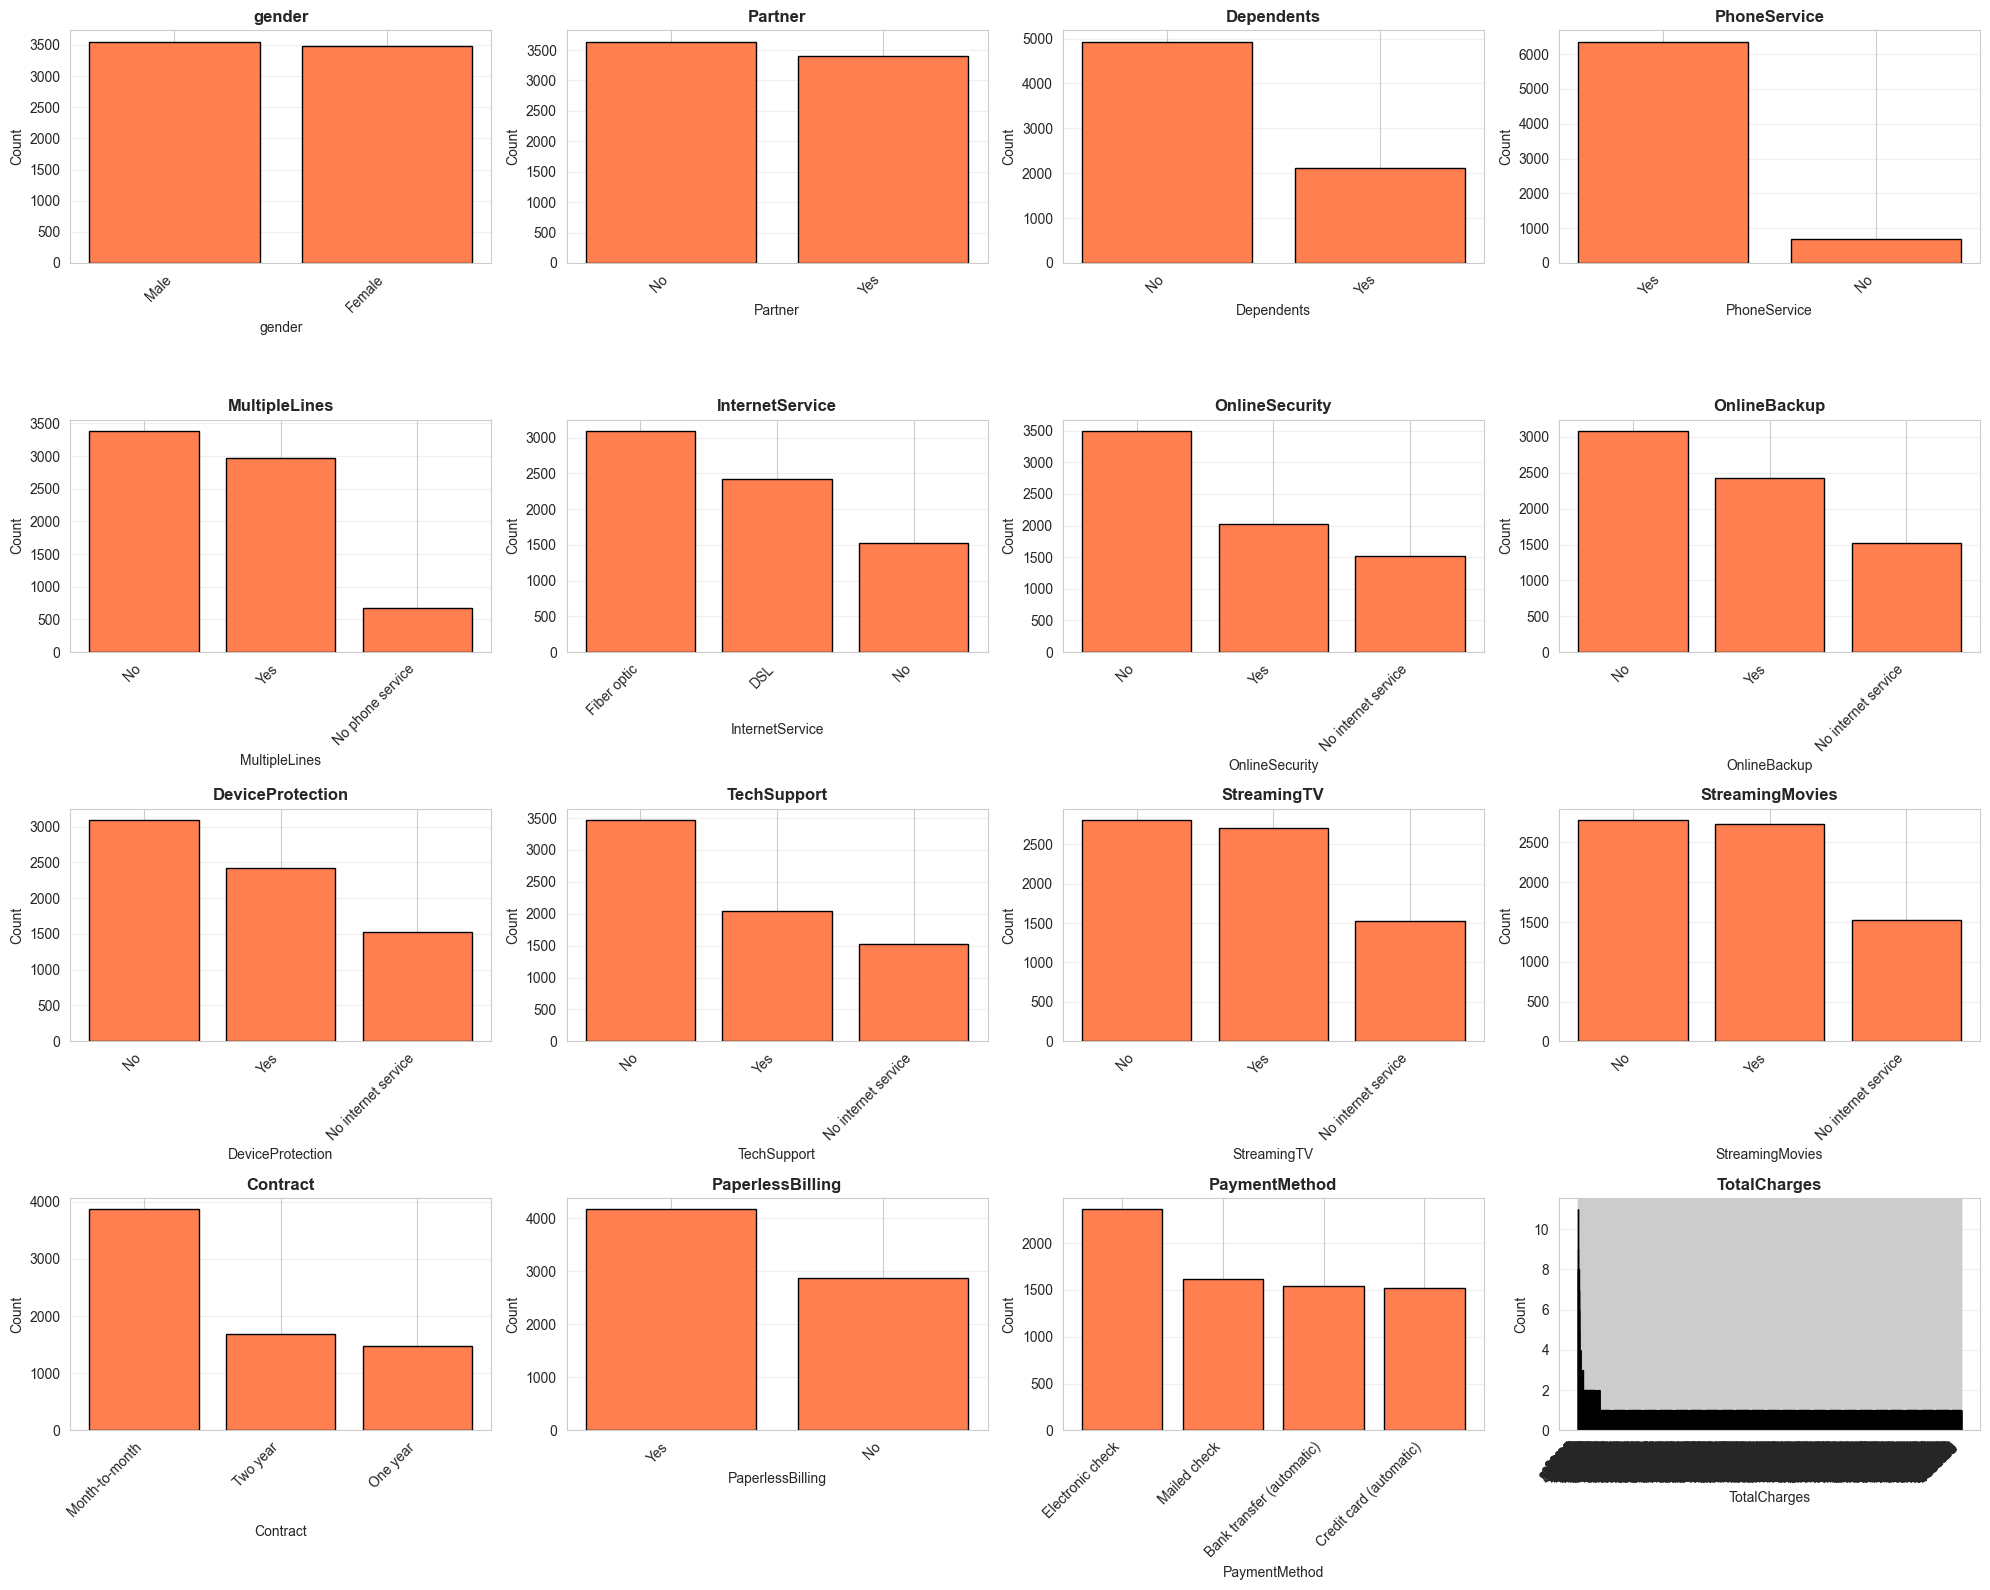


📊 Unique values per categorical variable:
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values


In [36]:
# Bar Plots for Categorical Variables
print("="*80)
print("BAR PLOTS FOR CATEGORICAL VARIABLES")
print("="*80)

# Plot first batch of categorical variables
n_cols = 4
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, col in enumerate(categorical_cols):
    if idx < len(axes):
        value_counts = df[col].value_counts()
        axes[idx].bar(range(len(value_counts)), value_counts.values, color='coral', edgecolor='black')
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].grid(alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Unique values per categorical variable:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

### Bivariate Analysis and Correlation

CORRELATION HEATMAP


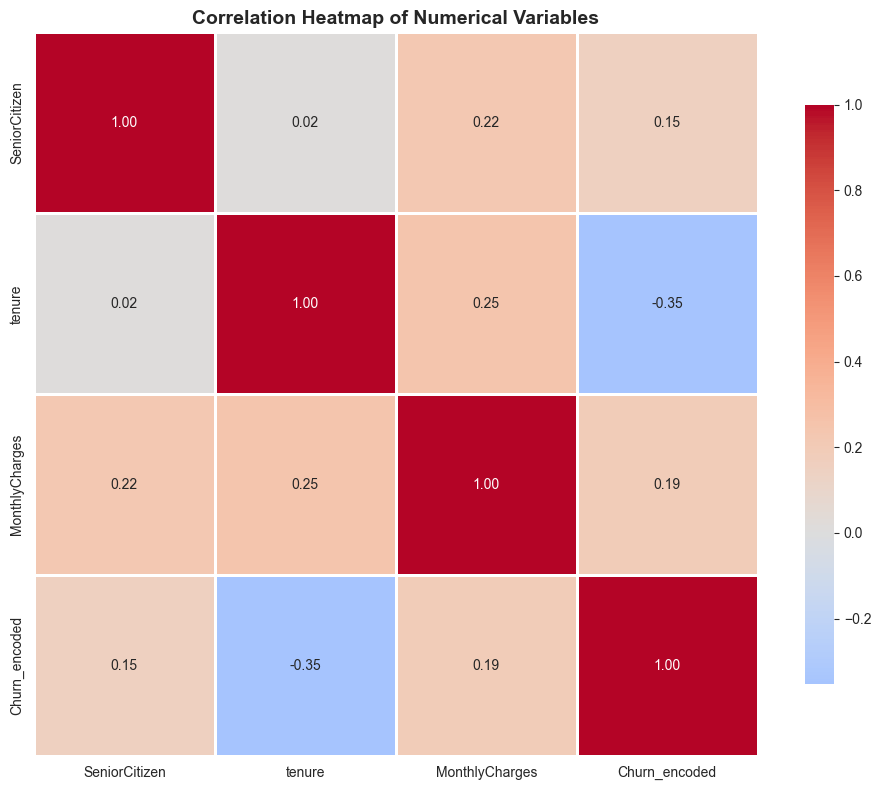


🎯 Correlation with Churn (sorted by absolute value):
tenure           -0.352229
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Name: Churn_encoded, dtype: float64


In [37]:
# Correlation Heatmap for Numerical Variables
print("="*80)
print("CORRELATION HEATMAP")
print("="*80)

# Create a copy and encode Churn for correlation
df_corr = df.copy()
df_corr['Churn_encoded'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# Select numerical columns including encoded target
corr_cols = numerical_cols + ['Churn_encoded']
correlation_matrix = df_corr[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Display correlations with target
print("\n🎯 Correlation with Churn (sorted by absolute value):")
churn_corr = correlation_matrix['Churn_encoded'].drop('Churn_encoded').sort_values(key=abs, ascending=False)
print(churn_corr)

BOXPLOTS: NUMERICAL FEATURES vs CHURN


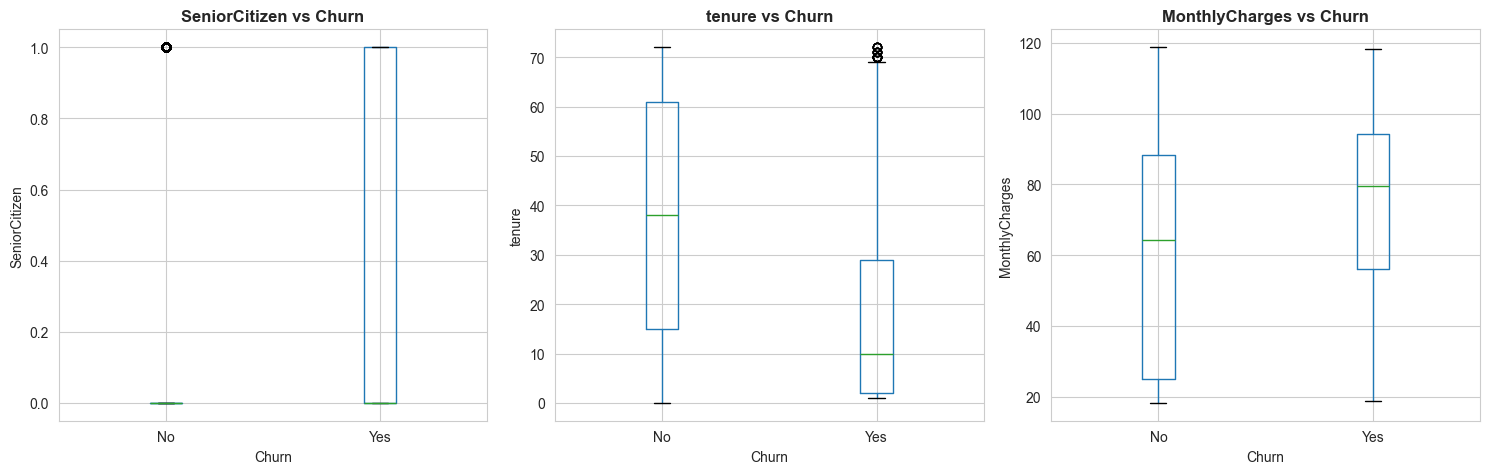


📊 Mean values by Churn status:
       SeniorCitizen     tenure  MonthlyCharges
Churn                                          
No          0.128721  37.569965       61.265124
Yes         0.254682  17.979133       74.441332


In [38]:
# Boxplots: Relationship between Numerical Features and Churn
print("="*80)
print("BOXPLOTS: NUMERICAL FEATURES vs CHURN")
print("="*80)

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 5))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Churn', ax=axes[idx])
    axes[idx].set_title(f'{col} vs Churn', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.suptitle('')  # Remove the default title
plt.tight_layout()
plt.show()

# Statistical comparison
print("\n📊 Mean values by Churn status:")
print(df.groupby('Churn')[numerical_cols].mean())

## Phase 2: Data Preprocessing 

### Handling Missing Values and Data Cleaning

In [39]:
# Create a working copy of the dataset
df_processed = df.copy()

print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Remove customerID as it's not useful for prediction
if 'customerID' in df_processed.columns:
    df_processed = df_processed.drop('customerID', axis=1)
    print("✓ Removed customerID column")

# Check for missing values
print(f"\n📊 Missing values before handling:")
missing_before = df_processed.isnull().sum()
print(missing_before[missing_before > 0])

# Handle TotalCharges if it's object type (common issue in this dataset)
if df_processed['TotalCharges'].dtype == 'object':
    print("\n⚠️ TotalCharges is object type - converting to numeric...")
    # Convert TotalCharges to numeric, coercing errors to NaN
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    print(f"✓ Converted TotalCharges to numeric")
    print(f"  Missing values created: {df_processed['TotalCharges'].isnull().sum()}")

# Imputation Strategy for TotalCharges
# Justification: For customers with 0 tenure, TotalCharges should be 0
# For others, we'll use median imputation based on similar MonthlyCharges
print("\n📝 Imputation Strategy:")
print("  - Customers with tenure=0 and missing TotalCharges → Fill with 0")
print("  - Others → Fill with median TotalCharges")

if df_processed['TotalCharges'].isnull().any():
    # Fill missing TotalCharges for tenure=0 customers with 0
    df_processed.loc[(df_processed['TotalCharges'].isnull()) & (df_processed['tenure'] == 0), 'TotalCharges'] = 0
    
    # Fill remaining missing values with median
    median_total_charges = df_processed['TotalCharges'].median()
    df_processed['TotalCharges'].fillna(median_total_charges, inplace=True)
    print(f"✓ Imputed missing TotalCharges values")

print(f"\n✅ Missing values after handling:")
missing_after = df_processed.isnull().sum()
if missing_after.sum() == 0:
    print("  No missing values remaining!")
else:
    print(missing_after[missing_after > 0])

print(f"\n📊 Final dataset shape: {df_processed.shape}")

DATA PREPROCESSING
✓ Removed customerID column

📊 Missing values before handling:
Series([], dtype: int64)

⚠️ TotalCharges is object type - converting to numeric...
✓ Converted TotalCharges to numeric
  Missing values created: 11

📝 Imputation Strategy:
  - Customers with tenure=0 and missing TotalCharges → Fill with 0
  - Others → Fill with median TotalCharges
✓ Imputed missing TotalCharges values

✅ Missing values after handling:
  No missing values remaining!

📊 Final dataset shape: (7043, 20)


### Encoding and Scaling 

In [40]:
# Identify binary and multi-category variables
print("="*80)
print("ENCODING CATEGORICAL VARIABLES")
print("="*80)

# Get all categorical columns (excluding target)
cat_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

# Identify binary variables (2 unique values)
binary_cols = [col for col in cat_cols if df_processed[col].nunique() == 2]
multi_cols = [col for col in cat_cols if df_processed[col].nunique() > 2]

print(f"\n📋 Binary Columns ({len(binary_cols)}): {binary_cols}")
print(f"📋 Multi-category Columns ({len(multi_cols)}): {multi_cols}")

# Label Encoding for binary variables
print("\n🔹 Applying Label Encoding to binary variables...")
le = LabelEncoder()
for col in binary_cols:
    df_processed[col] = le.fit_transform(df_processed[col])
    print(f"  ✓ {col}: {df_processed[col].unique()}")

# Encode target variable (Churn)
print("\n🎯 Encoding target variable (Churn)...")
df_processed['Churn'] = df_processed['Churn'].map({'No': 0, 'Yes': 1})
print(f"  ✓ Churn: {df_processed['Churn'].unique()}")

# One-Hot Encoding for multi-category variables
print("\n🔸 Applying One-Hot Encoding to multi-category variables...")
df_processed = pd.get_dummies(df_processed, columns=multi_cols, drop_first=True)
print(f"  ✓ Created {len([col for col in df_processed.columns if any(mc in col for mc in multi_cols)])} dummy variables")

print(f"\n📊 Dataset shape after encoding: {df_processed.shape}")
print(f"📋 New columns sample: {df_processed.columns.tolist()[:10]}...")

ENCODING CATEGORICAL VARIABLES

📋 Binary Columns (5): ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
📋 Multi-category Columns (10): ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

🔹 Applying Label Encoding to binary variables...
  ✓ gender: [0 1]
  ✓ Partner: [1 0]
  ✓ Dependents: [0 1]
  ✓ PhoneService: [0 1]
  ✓ PaperlessBilling: [1 0]

🎯 Encoding target variable (Churn)...
  ✓ Churn: [0 1]

🔸 Applying One-Hot Encoding to multi-category variables...
  ✓ Created 21 dummy variables

📊 Dataset shape after encoding: (7043, 31)
📋 New columns sample: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn']...


In [41]:
# Scaling Numerical Features
print("="*80)
print("SCALING NUMERICAL FEATURES")
print("="*80)

# Identify numerical columns (excluding target)
num_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in num_cols:
    num_cols.remove('Churn')

print(f"\n📊 Numerical columns to scale: {num_cols}")

# Use StandardScaler (z-score normalization)
print("\n🔧 Applying StandardScaler (z-score normalization)...")
scaler = StandardScaler()

# Store original values for comparison
original_values = df_processed[num_cols].head()

# Apply scaling
df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

print("✓ Scaling completed!")
print(f"\n📈 Before scaling (first 5 rows):")
print(original_values)
print(f"\n📉 After scaling (first 5 rows):")
print(df_processed[num_cols].head())

print(f"\n📊 Final preprocessed dataset shape: {df_processed.shape}")
print("✅ Preprocessing completed successfully!")

SCALING NUMERICAL FEATURES

📊 Numerical columns to scale: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges']

🔧 Applying StandardScaler (z-score normalization)...
✓ Scaling completed!

📈 Before scaling (first 5 rows):
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  
0                 1           29.85         29.85  
1                 0           56.95       1889.50  
2                 1           53.85        108.15  
3                 0           42.30       1840.75  
4            

## Phase 3: Feature Engineering & Selection 

### Feature Engineering 

In [42]:
# Feature Engineering - Creating New Meaningful Features
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Before scaling, we need to work with original data for some features
# Let's reload and create features before full preprocessing
df_fe = df.copy()

# Remove customerID
if 'customerID' in df_fe.columns:
    df_fe = df_fe.drop('customerID', axis=1)

# Handle TotalCharges conversion - ensure it's always numeric
# Strip whitespace and replace empty strings with NaN if it's object type
if df_fe['TotalCharges'].dtype == 'object':
    df_fe['TotalCharges'] = df_fe['TotalCharges'].str.strip().replace(['', ' '], np.nan)

# Always convert to numeric (handles both object and any other problematic types)
df_fe['TotalCharges'] = pd.to_numeric(df_fe['TotalCharges'], errors='coerce')

# Fill missing values
df_fe.loc[(df_fe['TotalCharges'].isnull()) & (df_fe['tenure'] == 0), 'TotalCharges'] = 0
df_fe['TotalCharges'].fillna(df_fe['TotalCharges'].median(), inplace=True)

# Verify the conversion was successful
print(f"Done TotalCharges converted to {df_fe['TotalCharges'].dtype}")

print("\nCreating New Features:")

# Feature 1: Average Monthly Charge per Tenure Month
# Insight: How much customer pays on average per month of their relationship
df_fe['AvgChargePerTenureMonth'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)  # +1 to avoid division by zero
print("  ✓ Created 'AvgChargePerTenureMonth': TotalCharges / (tenure + 1)")

# Feature 2: Tenure Groups (Binning)
# Insight: Categorize customers by loyalty duration
def tenure_group(tenure):
    if tenure <= 12:
        return 0  # 'New'
    elif tenure <= 24:
        return 1  # 'Medium'
    elif tenure <= 48:
        return 2  # 'Established'
    else:
        return 3  # 'Long-term'

df_fe['TenureGroup'] = df_fe['tenure'].apply(tenure_group)
print("  Done - Created 'TenureGroup': 0=New(0-12mo), 1=Medium(13-24mo), 2=Established(25-48mo), 3=Long-term(48+mo)")

# Feature 3: Has Multiple Services
# Insight: Customers with more services might be less likely to churn
services = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_fe['ServiceCount'] = 0
for service in services:
    if service in df_fe.columns:
        if service == 'InternetService':
            df_fe['ServiceCount'] += (df_fe[service] != 'No').astype(int)
        else:
            df_fe['ServiceCount'] += (df_fe[service] == 'Yes').astype(int)
print("  Done - Created 'ServiceCount': Total number of services subscribed")

# Feature 4: Charge Ratio
# Insight: How much of total charges comes from monthly charges
df_fe['ChargeRatio'] = df_fe['MonthlyCharges'] / (df_fe['TotalCharges'] + 1)  # +1 to avoid division by zero
print("  Done - Created 'ChargeRatio': MonthlyCharges / TotalCharges")

print(f"\n Dataset shape after feature engineering: {df_fe.shape}")
print("\n Sample of new features:")
print(df_fe[['tenure', 'TenureGroup', 'AvgChargePerTenureMonth', 'ServiceCount', 'ChargeRatio']].head(10))

FEATURE ENGINEERING
Done TotalCharges converted to float64

Creating New Features:
  ✓ Created 'AvgChargePerTenureMonth': TotalCharges / (tenure + 1)
  Done - Created 'TenureGroup': 0=New(0-12mo), 1=Medium(13-24mo), 2=Established(25-48mo), 3=Long-term(48+mo)
  Done - Created 'ServiceCount': Total number of services subscribed
  Done - Created 'ChargeRatio': MonthlyCharges / TotalCharges

 Dataset shape after feature engineering: (7043, 24)

 Sample of new features:
   tenure  TenureGroup  AvgChargePerTenureMonth  ServiceCount  ChargeRatio
0       1            0                14.925000             2     0.967585
1      34            2                53.985714             4     0.030124
2       2            0                36.050000             4     0.493358
3      45            2                40.016304             4     0.022967
4       2            0                50.550000             2     0.463151
5       8            0                91.166667             5     0.121302
6    

In [43]:
# Encode and prepare data with engineered features
print("="*80)
print("ENCODING DATA WITH NEW FEATURES")
print("="*80)

# Encode target
df_fe['Churn'] = df_fe['Churn'].map({'No': 0, 'Yes': 1})

# Encode binary variables
binary_cols_fe = [col for col in df_fe.select_dtypes(include=['object']).columns if df_fe[col].nunique() == 2]
le = LabelEncoder()
for col in binary_cols_fe:
    df_fe[col] = le.fit_transform(df_fe[col])

# One-hot encode multi-category variables
multi_cols_fe = [col for col in df_fe.select_dtypes(include=['object']).columns if df_fe[col].nunique() > 2]
df_fe = pd.get_dummies(df_fe, columns=multi_cols_fe, drop_first=True)

print(f"Encoding completed")
print(f"Final shape: {df_fe.shape}")

# Separate features and target
X = df_fe.drop('Churn', axis=1)
y = df_fe['Churn']

print(f"\n Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f" Target distribution:\n{y.value_counts()}")

ENCODING DATA WITH NEW FEATURES
Encoding completed
Final shape: (7043, 35)

 Features shape: (7043, 34)
 Target shape: (7043,)
 Target distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


### Feature Selection

Using both filter-based and model-based approaches

FILTER-BASED FEATURE SELECTION (ANOVA F-test)

 Top 15 Features by ANOVA F-test:
                                 Feature       Score
4                                 tenure  997.268010
10                           TenureGroup  953.850910
15           InternetService_Fiber optic  738.046042
30                     Contract_Two year  707.919254
32        PaymentMethod_Electronic check  706.195028
19      OnlineBackup_No internet service  385.698588
16                    InternetService_No  385.698588
25       StreamingTV_No internet service  385.698588
27   StreamingMovies_No internet service  385.698588
23       TechSupport_No internet service  385.698588
17    OnlineSecurity_No internet service  385.698588
21  DeviceProtection_No internet service  385.698588
8                           TotalCharges  288.278961
7                         MonthlyCharges  273.463704
6                       PaperlessBilling  268.985218

 Done - Selected 15 features using ANOVA


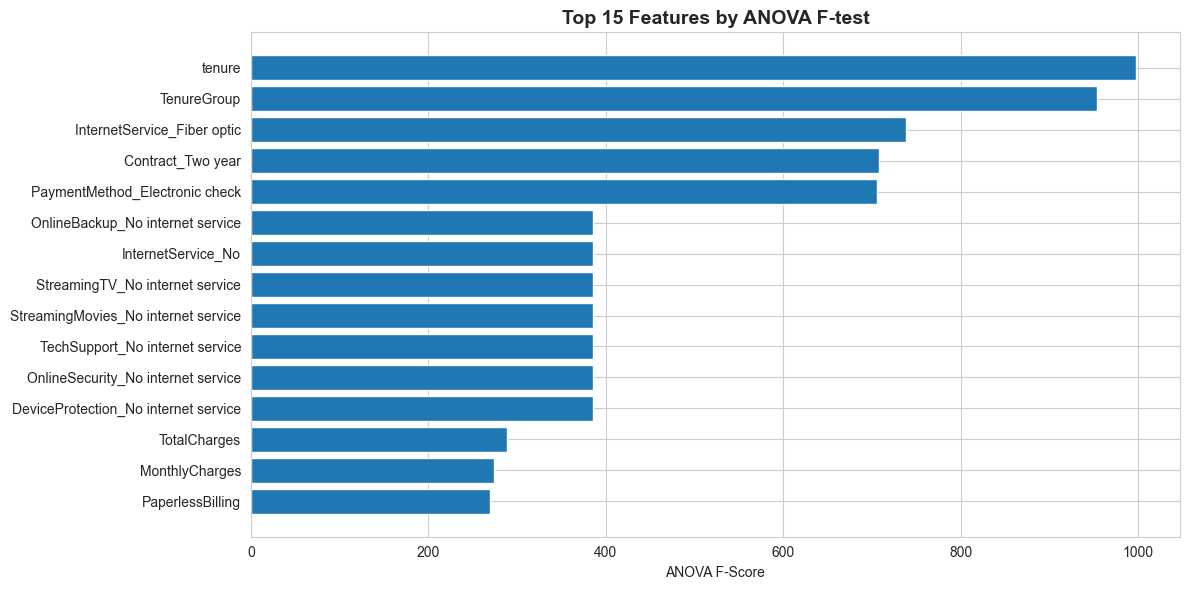

In [44]:
# Method 1: Filter-based - ANOVA F-test (for numerical features)
print("="*80)
print("FILTER-BASED FEATURE SELECTION (ANOVA F-test)")
print("="*80)

# Apply SelectKBest with ANOVA F-test
k_best = 15  # Select top 15 features
selector_anova = SelectKBest(score_func=f_classif, k=k_best)
selector_anova.fit(X, y)

# Get feature scores
feature_scores_anova = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_anova.scores_
}).sort_values(by='Score', ascending=False)

print(f"\n Top 15 Features by ANOVA F-test:")
print(feature_scores_anova.head(15))

# Get selected features
selected_features_anova = feature_scores_anova.head(k_best)['Feature'].tolist()
print(f"\n Done - Selected {len(selected_features_anova)} features using ANOVA")

# Visualize top 15 features
plt.figure(figsize=(12, 6))
top_15 = feature_scores_anova.head(15)
plt.barh(range(len(top_15)), top_15['Score'])
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('ANOVA F-Score')
plt.title('Top 15 Features by ANOVA F-test', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

MODEL-BASED FEATURE SELECTION (Random Forest)

 Top 15 Features by Random Forest Importance:
                           Feature  Importance
12                     ChargeRatio    0.148377
7                   MonthlyCharges    0.117539
8                     TotalCharges    0.114722
9          AvgChargePerTenureMonth    0.107045
4                           tenure    0.096227
15     InternetService_Fiber optic    0.034095
10                     TenureGroup    0.032826
11                    ServiceCount    0.032445
32  PaymentMethod_Electronic check    0.030958
30               Contract_Two year    0.022434
0                           gender    0.020804
6                 PaperlessBilling    0.020602
18              OnlineSecurity_Yes    0.017725
2                          Partner    0.017020
1                    SeniorCitizen    0.016371

Done - Selected 15 features using Random Forest


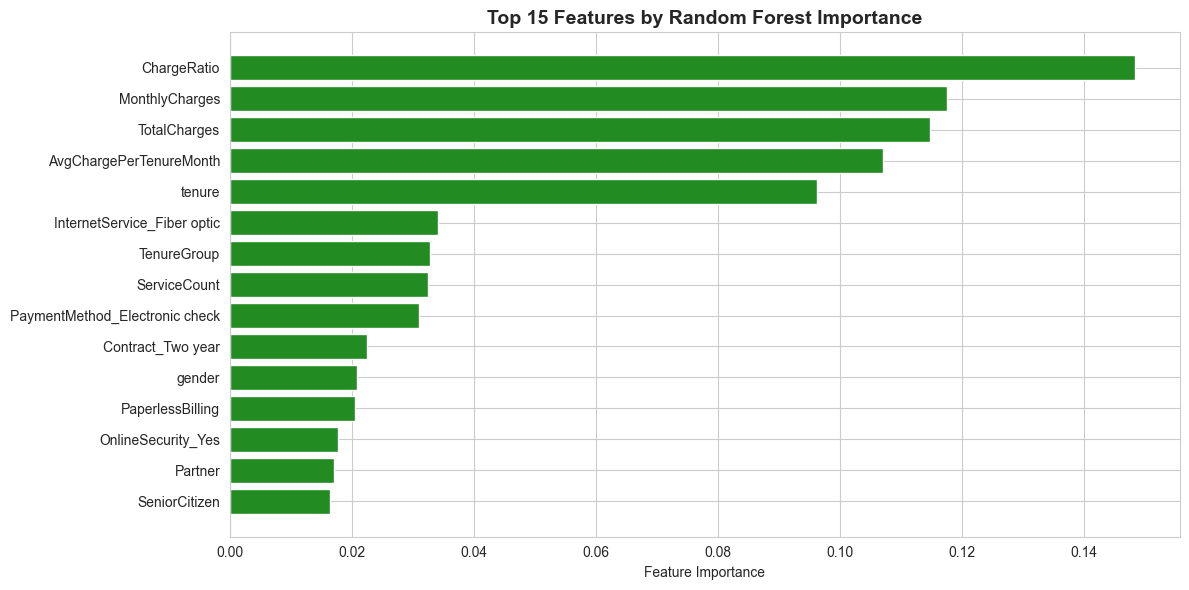

In [45]:
# Method 2: Model-based - Random Forest Feature Importance
print("="*80)
print("MODEL-BASED FEATURE SELECTION (Random Forest)")
print("="*80)

# Train Random Forest for feature importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X, y)

# Get feature importances
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(f"\n Top 15 Features by Random Forest Importance:")
print(feature_importance_rf.head(15))

# Get selected features
selected_features_rf = feature_importance_rf.head(k_best)['Feature'].tolist()
print(f"\nDone - Selected {len(selected_features_rf)} features using Random Forest")

# Visualize top 15 features
plt.figure(figsize=(12, 6))
top_15_rf = feature_importance_rf.head(15)
plt.barh(range(len(top_15_rf)), top_15_rf['Importance'], color='forestgreen')
plt.yticks(range(len(top_15_rf)), top_15_rf['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features by Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [46]:
# Combine and finalize feature selection
print("="*80)
print("FINAL FEATURE SELECTION")
print("="*80)

# Find common features between both methods
common_features = list(set(selected_features_anova) & set(selected_features_rf))
print(f"\n Common features in both methods: {len(common_features)}")
print(common_features)

# Combine top features from both methods (union of top 10 from each)
top_10_anova = selected_features_anova[:10]
top_10_rf = selected_features_rf[:10]
final_features = list(set(top_10_anova + top_10_rf))

print(f"\n Final Selected Features ({len(final_features)}):")
for i, feat in enumerate(final_features, 1):
    in_anova = "✓" if feat in top_10_anova else " "
    in_rf = "✓" if feat in top_10_rf else " "
    print(f"  {i:2d}. {feat:40s} [ANOVA: {in_anova}] [RF: {in_rf}]")

print("\n" + "="*80)
print("JUSTIFICATION FOR FINAL FEATURE SELECTION:")
print("="*80)
print("""
We selected the final feature subset using a hybrid approach:

1. **Filter-based (ANOVA F-test)**: Identifies features with strong statistical
   relationships with the target variable, independent of any model.

2. **Model-based (Random Forest)**: Captures feature interactions and non-linear
   relationships that might be missed by statistical tests.

3. **Final Selection Strategy**: We took the union of top 10 features from each
   method to ensure we capture both statistically significant features and those
   with strong predictive power in ensemble models.

4. **Benefits of this approach**:
   - Reduces dimensionality while retaining predictive power
   - Combines statistical significance with practical predictive value
   - Includes our engineered features if they prove valuable
   - Reduces risk of overfitting and improves model generalization
   - Maintains model interpretability with manageable number of features
""")

FINAL FEATURE SELECTION

 Common features in both methods: 8
['TotalCharges', 'Contract_Two year', 'InternetService_Fiber optic', 'MonthlyCharges', 'tenure', 'PaymentMethod_Electronic check', 'PaperlessBilling', 'TenureGroup']

 Final Selected Features (15):
   1. TechSupport_No internet service          [ANOVA: ✓] [RF:  ]
   2. TotalCharges                             [ANOVA:  ] [RF: ✓]
   3. Contract_Two year                        [ANOVA: ✓] [RF: ✓]
   4. InternetService_Fiber optic              [ANOVA: ✓] [RF: ✓]
   5. OnlineBackup_No internet service         [ANOVA: ✓] [RF:  ]
   6. ChargeRatio                              [ANOVA:  ] [RF: ✓]
   7. AvgChargePerTenureMonth                  [ANOVA:  ] [RF: ✓]
   8. ServiceCount                             [ANOVA:  ] [RF: ✓]
   9. MonthlyCharges                           [ANOVA:  ] [RF: ✓]
  10. InternetService_No                       [ANOVA: ✓] [RF:  ]
  11. PaymentMethod_Electronic check           [ANOVA: ✓] [RF: ✓]
  12. tenure   

In [47]:
# Prepare final dataset with selected features
X_selected = X[final_features].copy()
y_final = y.copy()

print("="*80)
print("FINAL DATASET FOR MODELING")
print("="*80)
print(f"\n Features shape: {X_selected.shape}")
print(f" Target shape: {y_final.shape}")
print(f"\n Selected features: {X_selected.columns.tolist()}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print(f"\n Data Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"\n  Training target distribution:")
print(f"    {y_train.value_counts()}")
print(f"  Test target distribution:")
print(f"    {y_test.value_counts()}")

FINAL DATASET FOR MODELING

 Features shape: (7043, 15)
 Target shape: (7043,)

 Selected features: ['TechSupport_No internet service', 'TotalCharges', 'Contract_Two year', 'InternetService_Fiber optic', 'OnlineBackup_No internet service', 'ChargeRatio', 'AvgChargePerTenureMonth', 'ServiceCount', 'MonthlyCharges', 'InternetService_No', 'PaymentMethod_Electronic check', 'tenure', 'StreamingTV_No internet service', 'TenureGroup', 'StreamingMovies_No internet service']

 Data Split:
  Training set: 5634 samples
  Test set: 1409 samples

  Training target distribution:
    Churn
0    4139
1    1495
Name: count, dtype: int64
  Test target distribution:
    Churn
0    1035
1     374
Name: count, dtype: int64


## Phase 4: Advanced Modeling & Optimization 
### Handling Imbalanced Data

HANDLING IMBALANCED DATA WITH SMOTE

📊 Class distribution before SMOTE:
  Class 0 (No Churn): 4139 (73.5%)
  Class 1 (Churn):    1495 (26.5%)

📈 Class distribution after SMOTE:
  Class 0 (No Churn): 4139 (50.0%)
  Class 1 (Churn):    4139 (50.0%)

✓ Training data size increased from 5634 to 8278


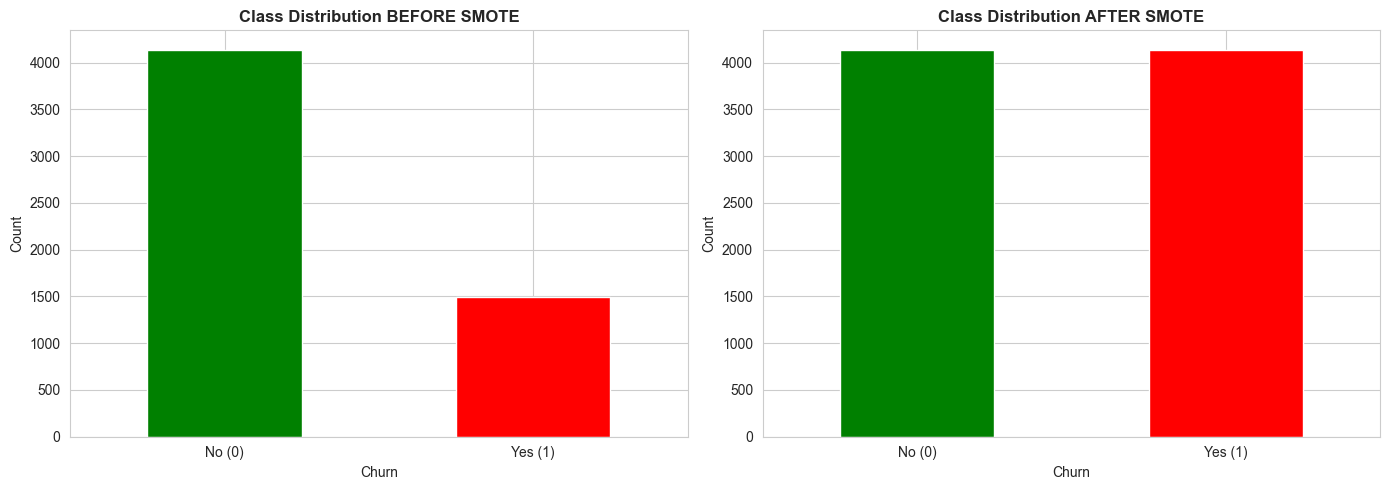

In [48]:
# Apply SMOTE to handle imbalanced data
print("="*80)
print("HANDLING IMBALANCED DATA WITH SMOTE")
print("="*80)

print("\n📊 Class distribution before SMOTE:")
print(f"  Class 0 (No Churn): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.1f}%)")
print(f"  Class 1 (Churn):    {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.1f}%)")

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n📈 Class distribution after SMOTE:")
print(f"  Class 0 (No Churn): {(y_train_smote == 0).sum()} ({(y_train_smote == 0).sum() / len(y_train_smote) * 100:.1f}%)")
print(f"  Class 1 (Churn):    {(y_train_smote == 1).sum()} ({(y_train_smote == 1).sum() / len(y_train_smote) * 100:.1f}%)")

print(f"\n✓ Training data size increased from {len(y_train)} to {len(y_train_smote)}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Class Distribution BEFORE SMOTE', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

# After SMOTE
pd.Series(y_train_smote).value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Class Distribution AFTER SMOTE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

plt.tight_layout()
plt.show()


### Base Models 

Training multiple classification models

In [49]:
# Initialize base models
print("="*80)
print("BASE MODELS TRAINING")
print("="*80)

# Dictionary to store results
results = {}

# Define base models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', n_jobs=-1)
}

print("\n🔧 Training models with SMOTE-balanced data...\n")

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train on SMOTE-balanced data
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Store results
    results[name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    # Format ROC-AUC for display
    roc_auc_str = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
    print(f"  ✓ {name} - Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc_str}")

print("\n✅ All base models trained successfully!")

BASE MODELS TRAINING

🔧 Training models with SMOTE-balanced data...

Training Logistic Regression...
  ✓ Logistic Regression - Recall: 0.7380, F1: 0.6154, ROC-AUC: 0.8256
Training KNN...
  ✓ KNN - Recall: 0.6390, F1: 0.5207, ROC-AUC: 0.7400
Training Random Forest...
  ✓ Random Forest - Recall: 0.6176, F1: 0.5697, ROC-AUC: 0.7945
Training Gradient Boosting...
  ✓ Gradient Boosting - Recall: 0.7299, F1: 0.6156, ROC-AUC: 0.8283
Training XGBoost...
  ✓ XGBoost - Recall: 0.6578, F1: 0.5885, ROC-AUC: 0.8172

✅ All base models trained successfully!


BASE MODELS PERFORMANCE COMPARISON

📊 Performance Metrics (sorted by Recall):
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.755145   0.527725 0.737968  0.615385 0.825630
  Gradient Boosting  0.757984   0.532164 0.729947  0.615558 0.828270
            XGBoost  0.755855   0.532468 0.657754  0.588517 0.817221
                KNN  0.687722   0.439338 0.639037  0.520697 0.740035
      Random Forest  0.752307   0.528604 0.617647  0.569667 0.794514


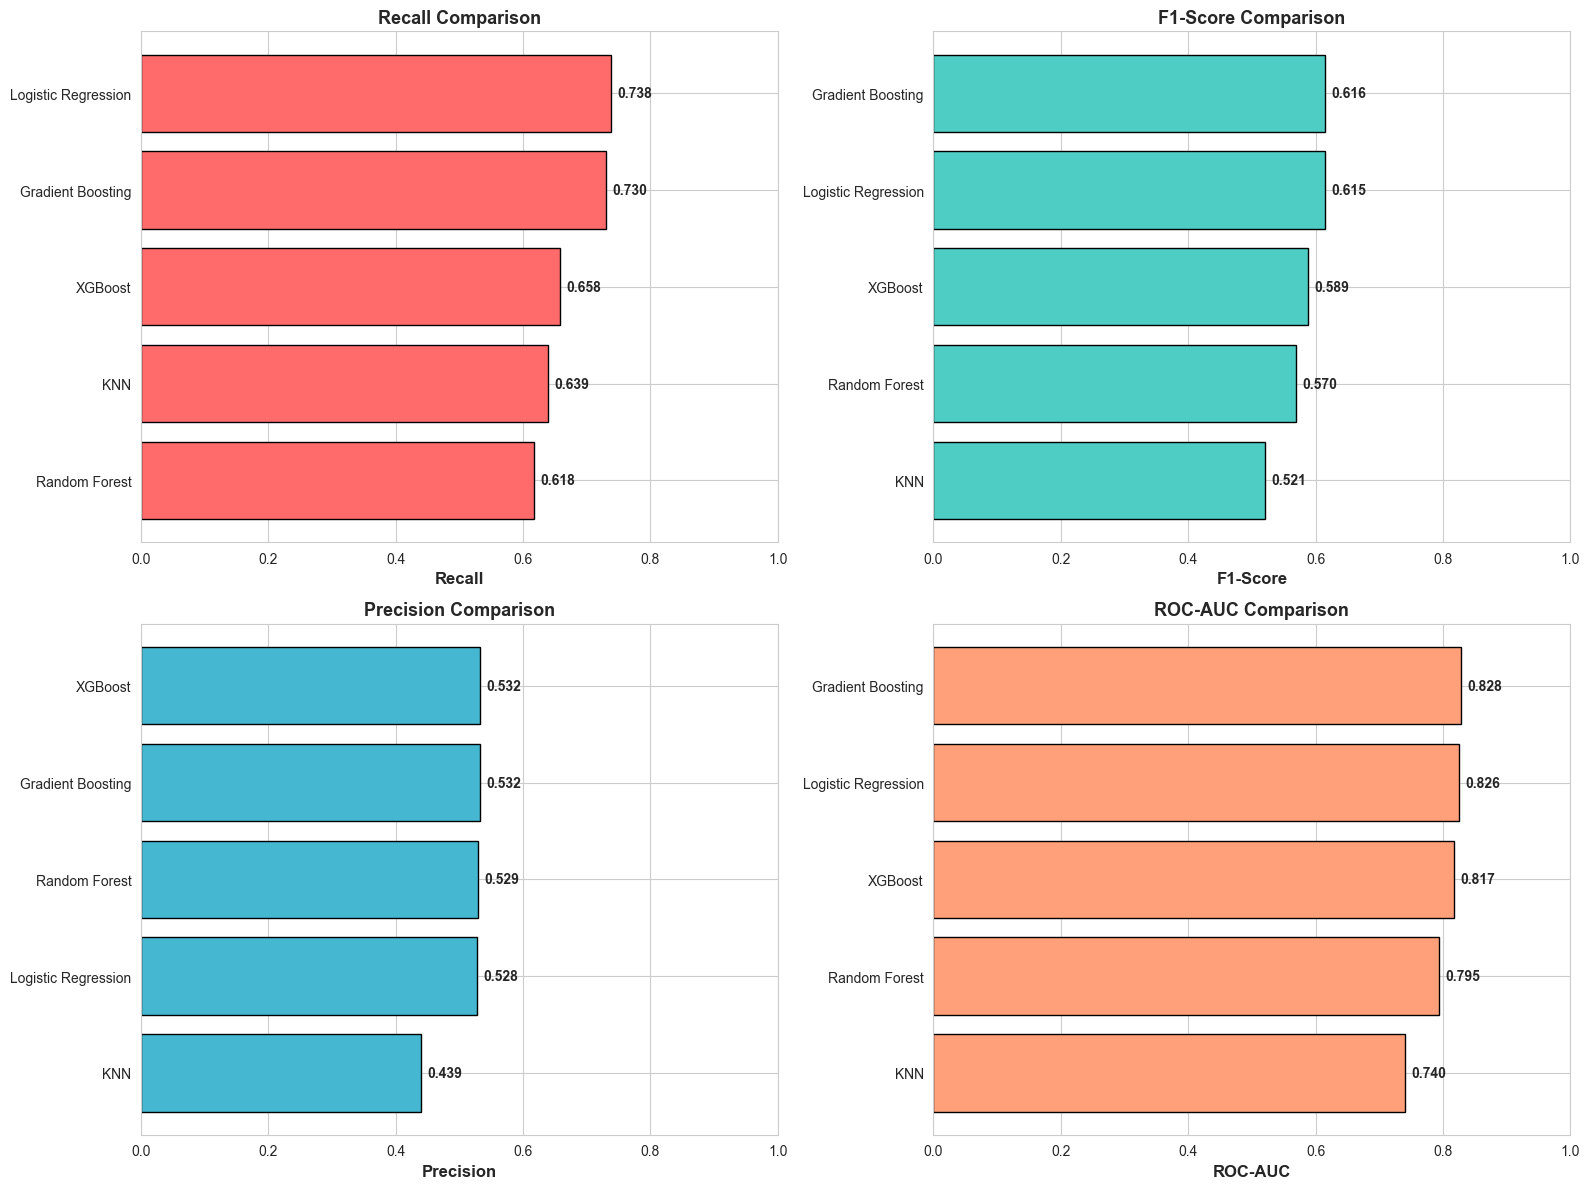


🏆 Best model by Recall: Logistic Regression
   Recall: 0.7380
   F1-Score: 0.6154


In [50]:
# Display results comparison
print("="*80)
print("BASE MODELS PERFORMANCE COMPARISON")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['Accuracy'] for m in results.keys()],
    'Precision': [results[m]['Precision'] for m in results.keys()],
    'Recall': [results[m]['Recall'] for m in results.keys()],
    'F1-Score': [results[m]['F1-Score'] for m in results.keys()],
    'ROC-AUC': [results[m]['ROC-AUC'] if results[m]['ROC-AUC'] else 0 for m in results.keys()]
})

# Sort by Recall (our primary metric)
results_df = results_df.sort_values(by='Recall', ascending=False)
print("\n📊 Performance Metrics (sorted by Recall):")
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Recall', 'F1-Score', 'Precision', 'ROC-AUC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    sorted_df = results_df.sort_values(by=metric, ascending=True)
    ax.barh(sorted_df['Model'], sorted_df[metric], color=color, edgecolor='black')
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🏆 Best model by Recall:", results_df.iloc[0]['Model'])
print(f"   Recall: {results_df.iloc[0]['Recall']:.4f}")
print(f"   F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

### Hyperparameter Tuning

Optimizing top performing models

In [51]:
# Hyperparameter tuning for Random Forest
print("="*80)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*80)

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

print("\n🔍 Searching for best parameters...")
print(f"   Parameter combinations to test: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * len(param_grid_rf['max_features']) * len(param_grid_rf['class_weight'])}")

# Use RandomizedSearchCV for efficiency
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=3,
    scoring='recall',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on SMOTE data
rf_random.fit(X_train_smote, y_train_smote)

print("\n✅ Best parameters found:")
for param, value in rf_random.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best cross-validation Recall score: {rf_random.best_score_:.4f}")

# Evaluate on test set
rf_tuned = rf_random.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test)
y_pred_proba_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_rf_tuned),
    'Precision': precision_score(y_test, y_pred_rf_tuned),
    'Recall': recall_score(y_test, y_pred_rf_tuned),
    'F1-Score': f1_score(y_test, y_pred_rf_tuned),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf_tuned)
}

print("\n📈 Tuned Random Forest Performance:")
for metric, value in rf_tuned_metrics.items():
    print(f"   {metric}: {value:.4f}")

# Store tuned model
results['Random Forest (Tuned)'] = {
    'Model': rf_tuned,
    'Accuracy': rf_tuned_metrics['Accuracy'],
    'Precision': rf_tuned_metrics['Precision'],
    'Recall': rf_tuned_metrics['Recall'],
    'F1-Score': rf_tuned_metrics['F1-Score'],
    'ROC-AUC': rf_tuned_metrics['ROC-AUC'],
    'Predictions': y_pred_rf_tuned,
    'Probabilities': y_pred_proba_rf_tuned
}

HYPERPARAMETER TUNING - RANDOM FOREST

🔍 Searching for best parameters...
   Parameter combinations to test: 432
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ Best parameters found:
   n_estimators: 100
   min_samples_split: 5
   min_samples_leaf: 2
   max_features: log2
   max_depth: 10
   class_weight: balanced

📊 Best cross-validation Recall score: 0.8377

📈 Tuned Random Forest Performance:
   Accuracy: 0.7480
   Precision: 0.5188
   Recall: 0.7005
   F1-Score: 0.5961
   ROC-AUC: 0.8234


In [53]:
# Hyperparameter tuning for XGBoost
print("="*80)
print("HYPERPARAMETER TUNING - XGBOOST")
print("="*80)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3]
}

print("\n🔍 Searching for best parameters...")

# Use RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    param_distributions=param_grid_xgb,
    n_iter=50,
    cv=3,
    scoring='recall',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on SMOTE data
xgb_random.fit(X_train_smote, y_train_smote)

print("\n✅ Best parameters found:")
for param, value in xgb_random.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best cross-validation Recall score: {xgb_random.best_score_:.4f}")

# Evaluate on test set
xgb_tuned = xgb_random.best_estimator_
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
y_pred_proba_xgb_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

# Calculate metrics
xgb_tuned_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb_tuned),
    'Precision': precision_score(y_test, y_pred_xgb_tuned),
    'Recall': recall_score(y_test, y_pred_xgb_tuned),
    'F1-Score': f1_score(y_test, y_pred_xgb_tuned),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_xgb_tuned)
}

print("\n📈 Tuned XGBoost Performance:")
for metric, value in xgb_tuned_metrics.items():
    print(f"   {metric}: {value:.4f}")

# Store tuned model
results['XGBoost (Tuned)'] = {
    'Model': xgb_tuned,
    'Accuracy': xgb_tuned_metrics['Accuracy'],
    'Precision': xgb_tuned_metrics['Precision'],
    'Recall': xgb_tuned_metrics['Recall'],
    'F1-Score': xgb_tuned_metrics['F1-Score'],
    'ROC-AUC': xgb_tuned_metrics['ROC-AUC'],
    'Predictions': y_pred_xgb_tuned,
    'Probabilities': y_pred_proba_xgb_tuned
}

HYPERPARAMETER TUNING - XGBOOST

🔍 Searching for best parameters...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

✅ Best parameters found:
   subsample: 0.6
   scale_pos_weight: 3
   n_estimators: 200
   max_depth: 3
   learning_rate: 0.01
   colsample_bytree: 0.8

📊 Best cross-validation Recall score: 0.9498

📈 Tuned XGBoost Performance:
   Accuracy: 0.6217
   Precision: 0.4068
   Recall: 0.9278
   F1-Score: 0.5656
   ROC-AUC: 0.8254


### Ensemble Method

Combining top models using Soft Voting

In [54]:
# Create Soft Voting Classifier with top 3 models
print("="*80)
print("ENSEMBLE MODELING - SOFT VOTING CLASSIFIER")
print("="*80)

# Select top 3 models based on Recall from base models
# We'll use: Random Forest (Tuned), XGBoost (Tuned), and Logistic Regression
print("\n🎯 Selected models for ensemble:")
print("   1. Random Forest (Tuned)")
print("   2. XGBoost (Tuned)")
print("   3. Logistic Regression")

# Create Soft Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_tuned),
        ('xgb', xgb_tuned),
        ('lr', LogisticRegression(random_state=42, max_iter=1000))
    ],
    voting='soft'
)

print("\n🔧 Training ensemble model...")
voting_clf.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred_voting = voting_clf.predict(X_test)
y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]

# Calculate metrics
voting_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'Precision': precision_score(y_test, y_pred_voting),
    'Recall': recall_score(y_test, y_pred_voting),
    'F1-Score': f1_score(y_test, y_pred_voting),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_voting)
}

print("\n✅ Ensemble model trained successfully!")
print("\n📈 Soft Voting Classifier Performance:")
for metric, value in voting_metrics.items():
    print(f"   {metric}: {value:.4f}")

# Store ensemble model
results['Soft Voting Ensemble'] = {
    'Model': voting_clf,
    'Accuracy': voting_metrics['Accuracy'],
    'Precision': voting_metrics['Precision'],
    'Recall': voting_metrics['Recall'],
    'F1-Score': voting_metrics['F1-Score'],
    'ROC-AUC': voting_metrics['ROC-AUC'],
    'Predictions': y_pred_voting,
    'Probabilities': y_pred_proba_voting
}

ENSEMBLE MODELING - SOFT VOTING CLASSIFIER

🎯 Selected models for ensemble:
   1. Random Forest (Tuned)
   2. XGBoost (Tuned)
   3. Logistic Regression

🔧 Training ensemble model...

✅ Ensemble model trained successfully!

📈 Soft Voting Classifier Performance:
   Accuracy: 0.7197
   Precision: 0.4831
   Recall: 0.8048
   F1-Score: 0.6038
   ROC-AUC: 0.8305


### Advanced Validation 

Stratified K-Fold Cross Validation

STRATIFIED K-FOLD CROSS VALIDATION

🔄 Performing 5-Fold Stratified Cross Validation on top models...
   Metric: Recall (primary focus)

Evaluating Random Forest (Tuned)...
   Mean Recall: 0.8432 (+/- 0.0021)
   Fold Scores: ['0.8406', '0.8430', '0.8418', '0.8440', '0.8466']

Evaluating XGBoost (Tuned)...
   Mean Recall: 0.9536 (+/- 0.0045)
   Fold Scores: ['0.9529', '0.9517', '0.9469', '0.9565', '0.9601']

Evaluating Soft Voting Ensemble...
   Mean Recall: 0.8857 (+/- 0.0064)
   Fold Scores: ['0.8768', '0.8829', '0.8829', '0.8924', '0.8937']

CROSS-VALIDATION SUMMARY

📊 Cross-Validation Results (sorted by Mean Recall):
                Model  Mean Recall  Std Recall
      XGBoost (Tuned)     0.953613    0.004486
 Soft Voting Ensemble     0.885723    0.006391
Random Forest (Tuned)     0.843199    0.002062


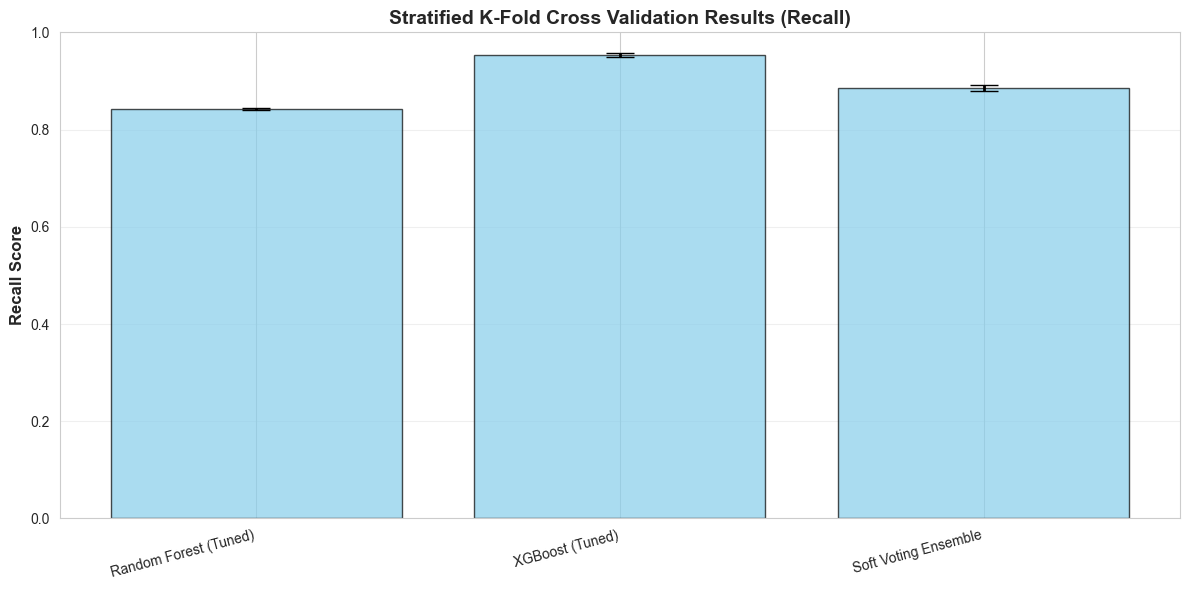


✅ Cross-validation completed!


In [55]:
# Stratified K-Fold Cross Validation
print("="*80)
print("STRATIFIED K-FOLD CROSS VALIDATION")
print("="*80)

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Select top models for cross-validation
top_models = {
    'Random Forest (Tuned)': rf_tuned,
    'XGBoost (Tuned)': xgb_tuned,
    'Soft Voting Ensemble': voting_clf
}

print("\n🔄 Performing 5-Fold Stratified Cross Validation on top models...")
print("   Metric: Recall (primary focus)\n")

cv_results = {}

for name, model in top_models.items():
    print(f"Evaluating {name}...")
    
    # Perform cross-validation on SMOTE data
    cv_scores = cross_val_score(model, X_train_smote, y_train_smote, 
                                cv=skf, scoring='recall', n_jobs=-1)
    
    cv_results[name] = {
        'Mean Recall': cv_scores.mean(),
        'Std Recall': cv_scores.std(),
        'All Scores': cv_scores
    }
    
    print(f"   Mean Recall: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"   Fold Scores: {[f'{score:.4f}' for score in cv_scores]}\n")

# Display summary
print("="*80)
print("CROSS-VALIDATION SUMMARY")
print("="*80)

cv_summary = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean Recall': [cv_results[m]['Mean Recall'] for m in cv_results.keys()],
    'Std Recall': [cv_results[m]['Std Recall'] for m in cv_results.keys()]
}).sort_values(by='Mean Recall', ascending=False)

print("\n📊 Cross-Validation Results (sorted by Mean Recall):")
print(cv_summary.to_string(index=False))

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
x_pos = range(len(cv_results))
means = [cv_results[m]['Mean Recall'] for m in cv_results.keys()]
stds = [cv_results[m]['Std Recall'] for m in cv_results.keys()]

plt.bar(x_pos, means, yerr=stds, alpha=0.7, color='skyblue', 
        edgecolor='black', capsize=10, error_kw={'linewidth': 2})
plt.xticks(x_pos, list(cv_results.keys()), rotation=15, ha='right')
plt.ylabel('Recall Score', fontsize=12, fontweight='bold')
plt.title('Stratified K-Fold Cross Validation Results (Recall)', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n✅ Cross-validation completed!")

## Phase 5: Evaluation & Final Repor

### Comprehensive Metrics Report 

In [56]:
# Comprehensive Metrics Table for All Models
print("="*80)
print("COMPREHENSIVE PERFORMANCE METRICS - ALL MODELS")
print("="*80)

# Create comprehensive results table
all_results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['Accuracy'] for m in results.keys()],
    'Precision': [results[m]['Precision'] for m in results.keys()],
    'Recall': [results[m]['Recall'] for m in results.keys()],
    'F1-Score': [results[m]['F1-Score'] for m in results.keys()],
    'ROC-AUC': [results[m]['ROC-AUC'] for m in results.keys()]
})

# Sort by Recall (primary metric)
all_results_df = all_results_df.sort_values(by='Recall', ascending=False)

print("\n📊 Complete Performance Metrics (sorted by Recall):")
print(all_results_df.to_string(index=False))

# Highlight best scores
print("\n🏆 Best Scores:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = all_results_df[metric].idxmax()
    best_model = all_results_df.loc[best_idx, 'Model']
    best_score = all_results_df.loc[best_idx, metric]
    print(f"   {metric:12s}: {best_model:30s} ({best_score:.4f})")

# Save results to CSV for reference
all_results_df.to_csv('model_performance_metrics.csv', index=False)
print("\n✓ Results saved to 'model_performance_metrics.csv'")

COMPREHENSIVE PERFORMANCE METRICS - ALL MODELS

📊 Complete Performance Metrics (sorted by Recall):
                Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      XGBoost (Tuned)  0.621718   0.406800 0.927807  0.565607 0.825387
 Soft Voting Ensemble  0.719659   0.483146 0.804813  0.603811 0.830523
  Logistic Regression  0.755145   0.527725 0.737968  0.615385 0.825630
    Gradient Boosting  0.757984   0.532164 0.729947  0.615558 0.828270
Random Forest (Tuned)  0.748048   0.518812 0.700535  0.596132 0.823420
              XGBoost  0.755855   0.532468 0.657754  0.588517 0.817221
                  KNN  0.687722   0.439338 0.639037  0.520697 0.740035
        Random Forest  0.752307   0.528604 0.617647  0.569667 0.794514

🏆 Best Scores:
   Accuracy    : Gradient Boosting              (0.7580)
   Precision   : XGBoost                        (0.5325)
   Recall      : XGBoost (Tuned)                (0.9278)
   F1-Score    : Gradient Boosting              (0.6156)
   ROC-AUC     : S